## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

## Получение данных

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()

,Uid,Device,End Ts,Source Id,Start Ts
0,16879256277535980062,touch,20.12.2017 17:38,4,20.12.2017 17:20
1,104060357244891740,desktop,19.02.2018 17:21,2,19.02.2018 16:53
2,7459035603376831527,touch,01.07.2017 1:54,5,01.07.2017 1:54
3,16174680259334210214,desktop,20.05.2018 11:23,9,20.05.2018 10:59
4,9969694820036681168,desktop,27.12.2017 14:06,3,27.12.2017 14:06


In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [4]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Данные загрузились успешно.
## Общие сведения о данных

In [5]:
visits.info()
print()
orders.info()
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


### Предварительные выводы по данным:
1. Пропуски на данном этапе не обнаружены;
2. Требуется преобразоваание данных в столбцах 'End Ts' и 'Start Ts' в visits, 'Buy Ts' в orders и 'dt' в costs к типу datetime;
3. Для удобства работы необходимо провести переименование столбцов в visits и orders: привести к нижнему регистру, заменить пробелы символом '_'.

## Обработка данных
### Предварительная обработка

In [6]:
visits.columns = ['uid','device','end_ts','source_id','start_ts']
orders.columns = ['buy_ts','revenue','uid']
visits['end_ts'] = pd.to_datetime(
    visits['end_ts'],
    format='%d.%m.%Y %H:%M'
)
visits['start_ts'] = pd.to_datetime(
    visits['start_ts'],
    format='%d.%m.%Y %H:%M'
)
orders['buy_ts'] = pd.to_datetime(
    orders['buy_ts'],
    format = '%Y-%m-%d %H:%M:%S'
)
costs['dt'] = pd.to_datetime(
    costs['dt'],
    format = '%Y-%m-%d'
)

### Детальное рассмотрение данных
#### Дубликаты

In [7]:
visits.duplicated().sum()

0

In [8]:
orders.duplicated().sum()

0

In [9]:
costs.duplicated().sum()

0

Дубликатов нет
#### Значения переменных

In [10]:
visits['device'].value_counts()

desktop    261913
touch       96619
Name: device, dtype: int64

In [11]:
visits['source_id'].value_counts().reset_index().sort_values('index')

,index,source_id
4,1,33943
3,2,47473
1,3,85448
0,4,101653
2,5,66711
8,6,6
7,7,36
5,9,13257
6,10,10005


Отсутствует 8 рекламный источник. Либо его нет, либо из него не приходят пользователи. Необходимо уточнить.

In [12]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

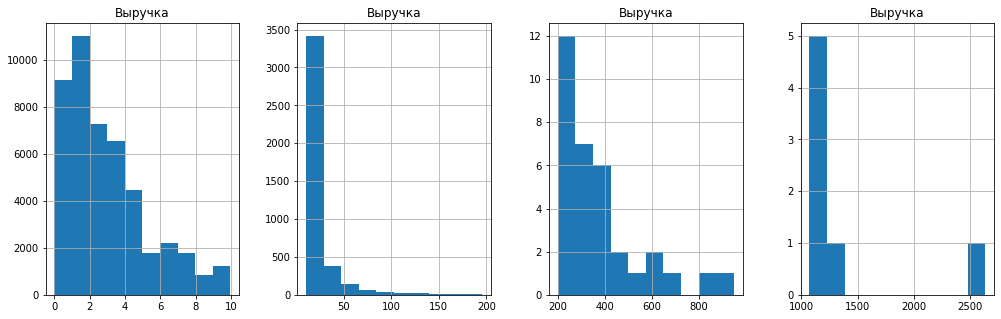

In [13]:
plt.subplots(figsize=(17,5))
plot = orders.query('revenue < 10').hist('revenue', ax=plt.subplot(1,4,1))
plt.title('Выручка')
plot = orders.query('10 < revenue < 200').hist('revenue', ax=plt.subplot(1,4,2))
plt.title('Выручка')
plot = orders.query('200 < revenue < 1000').hist('revenue', ax=plt.subplot(1,4,3))
plt.title('Выручка')
plot = orders.query('revenue > 1000').hist('revenue', ax=plt.subplot(1,4,4))
plt.title('Выручка');

Кажется, что основную долю выручки составляют небольшие отчисления. Крупных - от 200 рублей - единицы.

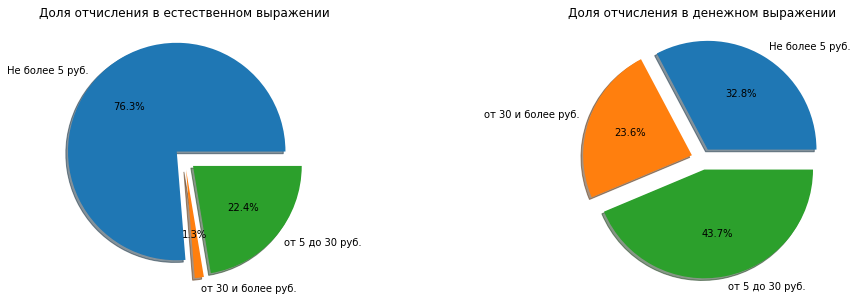

In [14]:
orders_cat = orders.copy()
def revenue_group(revenue):
    if revenue <= 5:
        return 'Не более 5 руб.'
    elif (revenue > 5) & (revenue <= 30):
        return 'от 5 до 30 руб.'
    else:
        return 'от 30 и более руб.'
orders_cat['category'] = orders_cat['revenue'].apply(revenue_group)
plt.subplots(figsize=(17,5))
plot = orders_cat.pivot_table(
    index='category',
    values='revenue',
    aggfunc='count'
).plot(
    kind='pie',
    autopct='%1.1f%%',
    title='Доля отчисления в естественном выражении',
    y='revenue',
    legend=False,
    explode=(0.1, 0.1, 0.1),
    shadow=True,
    ax = plt.subplot(1,2,1)
)
plt.ylabel('')
plot = orders_cat.pivot_table(
    index='category',
    values='revenue',
    aggfunc='sum'
).plot(
    kind='pie',
    autopct='%1.1f%%',
    title='Доля отчисления в денежном выражении',
    y='revenue',
    legend=False,
    explode=(0.1, 0.1, 0.1),
    shadow=True,
    ax = plt.subplot(1,2,2)
)
plt.ylabel('');

Несмотря на то, что малые отчисления (до 5 руб.) составляют 3/4 от общего количества, в денежном выражении они приносят 1/3 выручки. Почти половину выручки составляют отчисления от 5 до 30 р.
Отчисления от 30 рублей и более, составляющие в натуральном выражении менее 1,5 %, в денежном обуславливают почти четверть поступлений.

In [15]:
costs['source_id'].value_counts().reset_index().sort_values('index')

,index,source_id
3,1,363
6,2,363
2,3,363
5,4,363
0,5,364
1,9,363
4,10,363


Несмотря на то, что 6 и 7 рекламный источник не финансировались, пользователи из них приходят.

In [16]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

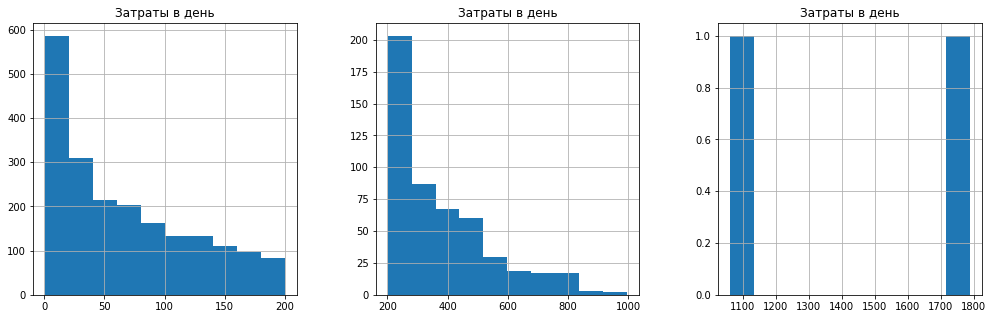

In [17]:
plt.subplots(figsize=(17,5))
plot = costs.query('costs < 200').hist('costs', ax=plt.subplot(1,3,1))
plt.title('Затраты в день')
plot = costs.query('200 < costs < 1000').hist('costs', ax=plt.subplot(1,3,2))
plt.title('Затраты в день')
plot = costs.query('costs > 1000').hist('costs', ax=plt.subplot(1,3,3))
plt.title('Затраты в день');

Очень редко затраты составляют более 1 000 рублей.

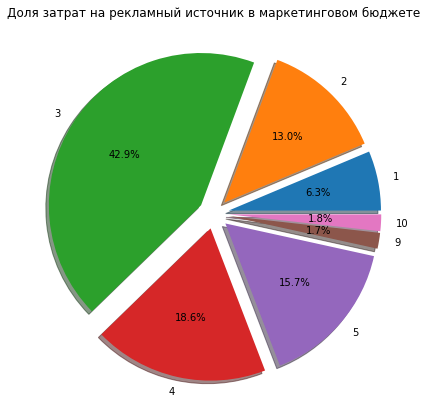

In [18]:
costs.pivot_table(
    index='source_id',
    values='costs',
    aggfunc='sum'
).plot(
    kind='pie',
    autopct='%1.1f%%',
    figsize=(7,7),
    title='Доля затрат на рекламный источник в маркетинговом бюджете',
    y='costs',
    legend=False,
    explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
    shadow=True,
)
plt.ylabel('');

### Выводы
Данные, содержащие временную метку (дату) преобразованы к типу datetime.
Переименованы названия столбцов.
При детальном рассмотрении данных не обнаружено каких-либо проблем.
Данные корректны.

Следует уточнить, существует ли 8 рекламный источник и в целом их количество и типы. 
## Отчеты и метрики
### Пользовательские метрики
#### Количество уникальных пользователей

In [19]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
dau_total = visits.groupby('session_date').agg({'uid':'nunique'}).mean()
wau_total = visits.groupby(['session_year','session_week']).agg({'uid':'nunique'}).mean()
mau_total = visits.groupby(['session_year','session_month']).agg({'uid':'nunique'}).mean()
sticky_factor_wau = dau_total / wau_total * 100
sticky_factor_mau = dau_total / mau_total * 100

In [20]:
print('Кол-во уникальных пользователей в день:',int(dau_total))
print()
print('Кол-во уникальных пользователей в неделю:',int(wau_total))
print()
print('Кол-во уникальных пользователей в месяц:',int(mau_total))
print()
print('Sticky factor (недельный):', int(sticky_factor_wau),'%')
print()
print('Sticky factor (месячный):', int(sticky_factor_mau),'%')

Кол-во уникальных пользователей в день: 907

Кол-во уникальных пользователей в неделю: 5716

Кол-во уникальных пользователей в месяц: 23228

Sticky factor (недельный): 15 %

Sticky factor (месячный): 3 %


#### Информация о пользовательских сессиях

<font><b><em>Количество сессий в день</em></b></font>

Группировка сессий по значению 'session_date', применение функций 'count' и 'nunique' по значению 'uid'

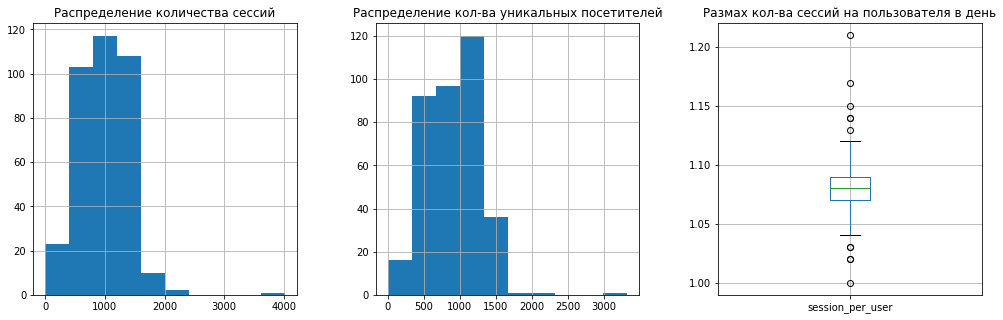

In [21]:
session_count = visits.groupby('session_date').agg({'uid':['count','nunique']})
session_count.columns = ('sess_number','users_number')
session_count['session_per_user'] = (session_count['sess_number'] / session_count['users_number']).round(2)
plt.subplots(figsize=(17,5))
plot = session_count.hist(
    'sess_number',
    ax = plt.subplot(1,3,1),
)
plt.title('Распределение количества сессий')
plot = session_count.hist(
    'users_number',
    ax = plt.subplot(1,3,2)
)
plt.title('Распределение кол-ва уникальных посетителей')
plot = session_count.boxplot(
    'session_per_user',
    ax = plt.subplot(1,3,3)
)
plt.title('Размах кол-ва сессий на пользователя в день');

Распределение количества сессий в день и уникальных посетителей за день схожее, а размах удельного количества сессий на пользователя невелик и находится в окрестности 1. Это говорит о том, что на одного уникального пользователя приходится одна сессия. 

По внешнему виду гистограммы сложно определить характер распределения. С помощью normaltest оценивается нормальность распределения. Значение alpha = 0,05 

Ho - распределение дневного числа сессий - нормальное, H1 - иное. 

In [22]:
alpha = .05
result_session = st.normaltest(
    session_count['sess_number']    
)
if result_session.pvalue < alpha:
    print('Нулевая гипотеза может быть отвергнута')
else:
    print('Нулевая гипотеза не может быть отвергнута')

Нулевая гипотеза может быть отвергнута


~~Количество сессий в день может быть оценено с помощью атрибута .mode()~~

Большинство значений все же сконцентрировано около 1 000 сессий в день, поэтому данные можно усреднить 

In [23]:
#print('Среднее количество сессий в день:', session_count['sess_number'].mode()) 
#на выходе - три значения. Выбрал то, что совпало с результатом вызова функции scipy.stats.mode()
# способ неинформативный

In [24]:
print('Среднее количество сессий в день:', int(session_count['sess_number'].mean()))

Среднее количество сессий в день: 984


<font><b><em>Продолжительность сессии</em></b></font>

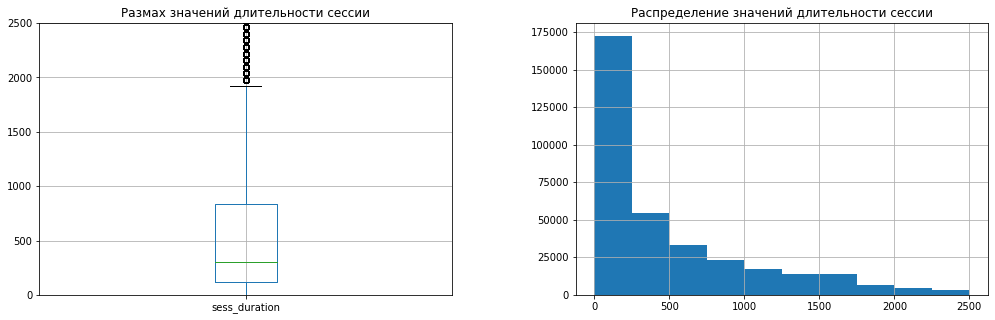

In [25]:
visits['sess_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
plt.subplots(figsize=(17,5))
plot = visits.boxplot(
    'sess_duration',
    ax = plt.subplot(1,2,1)
)
plt.title('Размах значений длительности сессии')
plt.ylim(0,2500)
plot = visits.hist(
    'sess_duration',
    ax = plt.subplot(1,2,2),
    range=(0,2500)
)
plt.title('Распределение значений длительности сессии');

In [26]:
sess_ratio = visits.query('sess_duration < 2500')['sess_duration'].count() / visits['sess_duration'].count()
print ('Доля сессий с длительностью до 2 500 секунд от общего числа сессий: {:.1%}'.format(sess_ratio)) 

Доля сессий с длительностью до 2 500 секунд от общего числа сессий: 95.8%


In [27]:
visits.query('sess_duration < 2500')['sess_duration'].median()

240.0

In [28]:
visits['sess_duration'].mode()[0]

60

<font><b><em>Retention Rate</em></b><font>

В распоряжении годовой объем данных, поэтому когорты будут сформированы по месяцам

In [29]:
first_activity_date = visits.groupby('uid')['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid')
visits['first_session_month'] = visits['first_activity_date'].astype('datetime64[M]')

In [30]:
visits['cohort_lftm'] = (visits['start_ts'] - visits['first_activity_date'])/ np.timedelta64(1,'M')
visits['cohort_lftm'] = visits['cohort_lftm'].round().astype('int')
cohorts = visits.groupby(['first_session_month','cohort_lftm']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lftm'] == 0][['first_session_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'n_cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts['retention'] = cohorts['uid'] / cohorts['n_cohort_users'] 
cohorts['first_session_month'] = cohorts['first_session_month'].dt.strftime('%Y-%m')

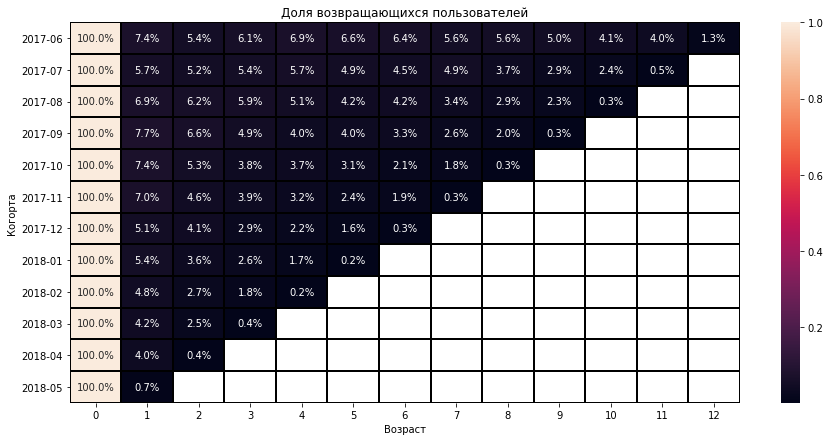

In [31]:
retention_pivot = cohorts.pivot_table(
    index = 'first_session_month',
    columns = 'cohort_lftm',
    values = 'retention',
    aggfunc = 'sum'
)
plt.figure(figsize=(15,7))
plt.title('Доля возвращающихся пользователей')
sns.heatmap(
    retention_pivot,
    annot = True,
    fmt = '.1%',
    linewidths=1,
    linecolor='black'
)
plt.xlabel('Возраст')
plt.ylabel('Когорта');

#### Выводы

Среднее дневное количество уникальных пользователей за рассматриваемый период - порядка 900 человек, недельное - чуть более 5500 человек, месячное - почти 23,5 тыс.человек. Недельный Sticky-фактор составляет 15 %, месячный - 3 %, т.е регулярность использования низкая.

В средним в день совершается около 1 000 сессий. Медианная продолжительность сессии при этом - 4 минуты, а сессии за очень редким исключением длятся более 40 минут - таких менее 5 %.

Коэффициент удержания пользователей низкий, при этом наблюдается тенденция падения показателя с течением времени. Так, в когорте 2018-05 уже на первый месяц количество возвращающихся пользователей составляет всего 0,7 %, хотя для когорты 2017-06 подобных пользователей было 7,4 %. Быстрее стал сокращаться с возрастом коэффициент удержания у более молодых когорт. 

### Продажи
#### Средний чек

In [32]:
first_order_date = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order_date.columns = ['uid','first_order_date']
orders_check = pd.merge(orders,first_order_date, on='uid')

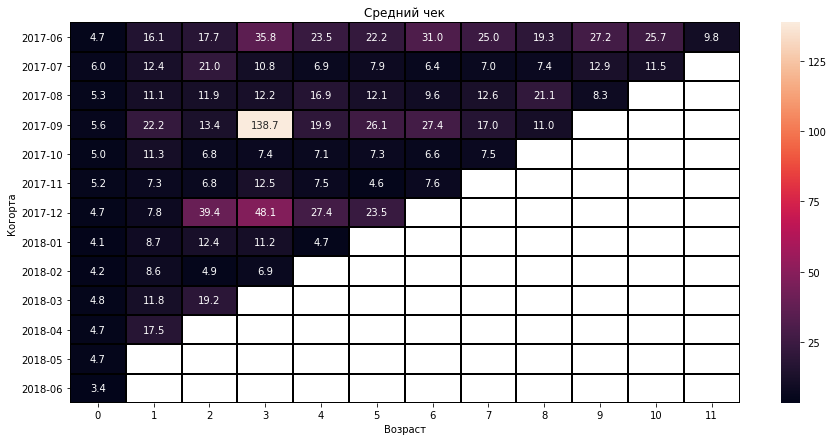

In [33]:
orders_check['first_order_month'] = orders_check['first_order_date'].astype('datetime64[M]')
orders_check['order_month'] = orders_check['buy_ts'].astype('datetime64[M]')
orders_group_by_cohorts = orders_check.groupby(
    ['first_order_month','order_month']).agg({'uid':'nunique','revenue':'sum'}).reset_index()
orders_group_by_cohorts['revenue_per_user'] = orders_group_by_cohorts['revenue'] / orders_group_by_cohorts['uid']
orders_group_by_cohorts['cohort_lifetime'] = (
    (orders_group_by_cohorts['order_month'] - 
    orders_group_by_cohorts['first_order_month'])/np.timedelta64(1,'M')
).round().astype('int')
orders_group_by_cohorts['first_order_month'] = orders_group_by_cohorts['first_order_month'].dt.strftime('%Y-%m')
orders_pivot_revenue = orders_group_by_cohorts.pivot_table(
    index = 'first_order_month',
    columns = 'cohort_lifetime',
    values = 'revenue_per_user',
    aggfunc = 'mean'
)
plt.figure(figsize=(15,7))
plt.title('Средний чек')
sns.heatmap(
    orders_pivot_revenue,
    annot = True,
    fmt='.1f',
    linewidths = 1,
    linecolor = 'black'
)
plt.xlabel('Возраст')
plt.ylabel('Когорта');

Средний чек внутри когорт имеет тенденцию к росту в сравнении с начальным значением. Связано это, в том числе, со снижением количества активных покупателей внутри когорты, что было показано ранее при рассмотрении коэффициента удержания пользователей. Можно заключить, что те клиенты, что продолжают использовать сервис являются более платежеспособными, нежели средний пользователь.

Какой-то однозначной закономерности между номером когорты и средним чеком нет. Выделяются отдельные когороты - 2017-06, 2017-09 (самое высокок значение среднего чека приходится на декабрь 2018 года, очевидно, это связано с приближением нового года), 2017-12.

#### Количество покупок

In [34]:
orders_grouped_by_cohort_II = orders_check.groupby(
    ['first_order_month','order_month']).agg({'uid':'count'}).reset_index()
orders_grouped_by_cohort_II['cohort_lifetime'] = (
    (orders_grouped_by_cohort_II['order_month'] - 
     orders_grouped_by_cohort_II['first_order_month'])/np.timedelta64(1,'M')
).round().astype('int')
orders_grouped_by_cohort_II['first_order_month'] = orders_grouped_by_cohort_II['first_order_month'].dt.strftime('%Y-%m')
orders_number_pivot = orders_grouped_by_cohort_II.pivot_table(
    index = 'first_order_month',
    columns = 'cohort_lifetime',
    values = 'uid',
    aggfunc = 'mean'
)
orders_number_pivot.columns.name = 'Возраст когорты, мес'
orders_number_pivot.index.name = 'Когорта'
orders_number_pivot = orders_number_pivot.fillna('')
print('Количество покупок в когортах по месяцам')
orders_number_pivot

Количество покупок в когортах по месяцам


"Возраст когорты, мес",0,1,2,3,4,5,6,7,8,9,10,11
Когорта,,,,,,,,,,,,
2017-06,2354.0,177,174,226,292,218,276,174,212,153,96,86
2017-07,2186.0,100,120,104,72,82,61,50,58,24,53,
2017-08,1533.0,108,100,81,85,62,49,78,46,46,,
2017-09,2933.0,219,161,164,67,109,108,56,61,,,
2017-10,4964.0,314,162,122,129,103,86,125,,,,
2017-11,4813.0,397,182,211,136,59,102,,,,,
2017-12,5052.0,270,202,179,86,105,,,,,,
2018-01,3783.0,224,159,64,78,,,,,,,
2018-02,4095.0,222,83,70,,,,,,,,


В отчете о количестве покупок наблюдается подобная закономерность, что и в отчете о коэф.удержания посетителей. Выделяется первая когорта - месячное количество покупок сохраняется примерно на одном уровне достаточно дилтельное время. Между когортами наблюдается сначала увеличение количества покупок, а затем его снижение, так, наиболее покупающими оказались когорты 2017-10, 2017-11, 2017-12, причем не только в первый месяц, но и в последующие.   

#### LTV

In [35]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]') 
first_orders = orders.groupby('uid').agg({'order_month':'min'}).reset_index()
first_orders.columns = ['uid','first_order_month']

In [36]:
cohorts_size = first_orders.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohorts_size.columns = ['first_order_month','n_users']

In [37]:
orders_ltv = pd.merge(orders, first_orders, on='uid')
cohorts = orders_ltv.groupby(['first_order_month','order_month']).agg({'revenue':'sum'}).reset_index()

In [38]:
report = pd.merge(cohorts_size, cohorts, on='first_order_month')
report['age'] = (report['order_month'] - report['first_order_month'])/np.timedelta64(1,'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_users']

In [39]:
output = report.pivot_table(
    index = 'first_order_month',
    columns = 'age',
    values = 'ltv',
    aggfunc = 'mean'
).round(2)
output.columns.name = 'Возраст'
output.index.name = 'Когорта'
output = output.fillna('')

In [40]:
print('Ценность клиента в зависимости от возраста')
output

Ценность клиента в зависимости от возраста


Возраст,0,1,2,3,4,5,6,7,8,9,10,11
Когорта,,,,,,,,,,,,
2017-06-01,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07-01,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08-01,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09-01,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10-01,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11-01,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12-01,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02-01,4.16,0.28,0.08,0.07,,,,,,,,


Показатель LTV падает в когортах с возрастом, так как активных пользователей остается все меньше и меньше. 
#### Период, после которого пользователи начинают покупать

In [41]:
#группировка данных о визитах по посетителям и выбор первой даты визита
visiters_grouped = visits.groupby('uid').agg({'start_ts':'min'}).reset_index()
#группировка данных о заказах по покупателям и выбор первой даты заказа
buyers_grouped = orders.groupby('uid').agg({'buy_ts':'min'})
#объединенная таблица содержит данные о первом визите и первой покупке пользователя
visiting_buying = pd.merge(visiters_grouped, buyers_grouped, on='uid')
#время, прошедшее между визитом и покупкой
visiting_buying['time_passed'] = visiting_buying['buy_ts'] - visiting_buying['start_ts']
#фильтр значений разницы во времени, принят 5 секунд (были и отрицательные значения)
buy_report = visiting_buying[visiting_buying['time_passed'] > datetime.timedelta(seconds=5)]
#минуты между первым визитом и покупкой
buy_report['time_passed'] = buy_report['time_passed'].astype('timedelta64[m]')

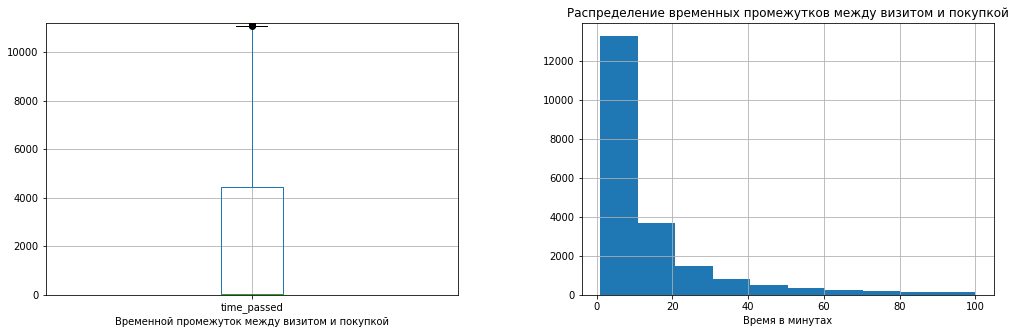

In [42]:
plt.subplots(figsize=(17,5))
plot = buy_report.boxplot(
    'time_passed',
    ax = plt.subplot(1,2,1)
)
plt.ylim(0,11200)
plt.xlabel('Временной промежуток между визитом и покупкой')
plot = buy_report.hist(
    'time_passed',
    range=(1,100),
    ax = plt.subplot(1,2,2)
)
plt.title('Распределение временных промежутков между визитом и покупкой')
plt.xlabel('Время в минутах');

В большинстве случаев факт первого посещения и факт покупки разделяет небольшой временной промежуток - не более 10-20 минут.

In [43]:
buy_report['time_passed'].describe()

count     34068.000000
mean      26094.171715
std       69857.874308
min           1.000000
25%           5.000000
50%          21.000000
75%        4438.000000
max      523144.000000
Name: time_passed, dtype: float64

### Маркетинг
#### Суммарные расходы с разбивкой по источникам и месяцам

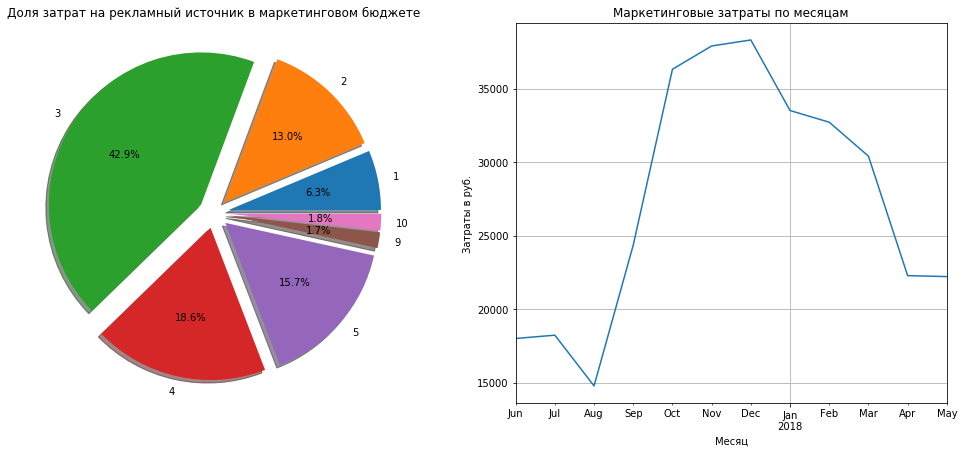

In [44]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_sum = costs['costs'].sum()
plt.subplots(figsize=(17,7))
plot = costs.pivot_table(
    index='source_id',
    values='costs',
    aggfunc='sum'
).plot(
    kind='pie',
    autopct='%1.1f%%',
    title='Доля затрат на рекламный источник в маркетинговом бюджете',
    y='costs',
    legend=False,
    explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
    shadow=True,
    ax = plt.subplot(1,2,1)
)
plt.ylabel('')
plot = costs.pivot_table(
    index='month',
    values='costs',
    aggfunc='sum'   
).reset_index().plot(
    x='month',
    y='costs',
    grid=True,
    legend=False,
    ax = plt.subplot(1,2,2),
    title = 'Маркетинговые затраты по месяцам'
)
plt.ylabel('Затраты в руб.')
plt.xlabel('Месяц');

In [45]:
print('Суммарные затраты на маркетинг за рассматриваемый период', costs_sum, 'рублей')

Суммарные затраты на маркетинг за рассматриваемый период 329131.62 рублей


Затраты на маркетинг имеют явный сезонный характер - спадают летом, начинаю расти осенью, достигая пика к новогодним каникулам и плавно снижаются весной.
Почти половина вложений пришлась на источник № 3, после чего практически равные доли приходятся на источники № 2, № 4 и № 5. 

Источники №№1, 10 и 9 финансировались по остаточному принципу.
#### Стоимость привлечения покупателя из каждого источника

In [46]:
#соответствие посетителя рекламному источнику из условия, что самый ранний переход посетителя приводил к покупке: 
clients_group_id = visits.groupby(['uid','source_id']).agg({'start_ts':'min'}).reset_index()
clients_id_source = clients_group_id[['uid','source_id']]
#суммарно потраченные средства на каждый источник:
sources_cost = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
#соответствие источника заказу:
source_orders = pd.merge(clients_id_source, orders, on='uid')
#группировка по источнику, подсчет числа уникальных покупателей и суммарной выручки от покупателей из 1 источника :
orders_grouped_by_sources = source_orders.groupby('source_id').agg({'uid':'nunique','revenue':'sum'}).reset_index()
orders_grouped_by_sources.columns = ['source_id','n_buyers','sum_revenue']
#таблица соответстия затрат количеству привлеченных покупателей:
cost_report = pd.merge(orders_grouped_by_sources, sources_cost, on='source_id')
#отношение затрат к количеству покупателей
cost_report['costs_per_user'] = cost_report['costs'] / cost_report['n_buyers']
#отношение выручки к количеству покупателей
cost_report['revenue_per_user'] = cost_report['sum_revenue'] / cost_report['n_buyers']

In [47]:
cost_report['costs_per_user'] = cost_report['costs_per_user'].round(2)
cost_report['revenue_per_user'] = cost_report['revenue_per_user'].round(2)
cost_report.columns = ['Источник','Кол-во покупателей','Выручка','Затраты','Уд.затраты','Уд.выручка']
cost_report

,Источник,Кол-во покупателей,Выручка,Затраты,Уд.затраты,Уд.выручка
0,1,7138,101631.38,20833.27,2.92,14.24
1,2,7305,113524.51,42806.04,5.86,15.54
2,3,13846,119193.48,141321.63,10.21,8.61
3,4,14253,119899.47,61073.60,4.28,8.41
4,5,10156,111532.65,51757.10,5.10,10.98
5,9,2793,18809.68,5517.49,1.98,6.73
6,10,1773,8218.72,5822.49,3.28,4.64


Несмотря на то, что вложения в 3 источник оказались самыми большими на данный момент они еще не окупились. Инвестиции в остальные источники окупились в некоторых случаях многократно, особенно для источника № 1, где каждый вложенный рубль дал почти 5 рублей выручки. Вероятно, следует пересмотреть структуру вложений.

#### ROI

In [48]:
monthly_cost = costs.groupby('month').agg({'costs':'sum'}).reset_index()
report_roi = pd.merge(report, monthly_cost, left_on='first_order_month', right_on='month')
report_roi['cac'] = report_roi['costs'] / report_roi['n_users']
report_roi['roi'] = report_roi['ltv'] / report_roi['cac']
output_roi = report_roi.pivot_table(
    index = 'first_order_month',
    columns = 'age',
    values = 'roi',
    aggfunc = 'mean'
)
output_roi.columns.name = 'Возраст, мес'
output_roi.index.name = 'Когорта'
output_roi.cumsum(axis=1).round(2).fillna('')

"Возраст, мес",0,1,2,3,4,5,6,7,8,9,10,11
Когорта,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


In [49]:
output_roi.cumsum(axis=1).mean(axis=0)

Возраст, мес
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

За редким исключением, ни одна когорта не окупила инвестиции в собственное привлечение. И для "средней когорты" период окупаемости составляет практически год (около 10 месяцев). Рассматрия структуру вложений по источникам и сопоставляя удельную выручку и удельные затраты по рекламным источникам следует отметить, что ставка на 3 источник являлась ошибочной.  

## Общие выводы
1. Сервис имеет большой потенциал, однако, сейчас обладает крайне малым количеством постоянных клиентов и это системное явление, повторяющееся со временем и имеющем даже негативную динамику. Необходимо развививать программу лояльности.
2. Большинство обращений пользователей к сервису не превышают 40 минут, среднее время - 4 минуты, а наиболее часто повторяющееся - 60 с - слишком мало для того, чтобы выбрать событие, прочесть о нем всю информацию и купить билет. Вероятно, существует что-то отталкивающее пользователей.


3. Сумма среднего чека увеличивается с течением времени в когортах относительно начального значения, что связано с уменьшением количества покупателей. Отдельно выделяется первая когорта 2017-06, средний чек в которой исчисляется десятками рублей достаточно долгое время. Подробно изучив эту когорту, можно оценить факторы, влияющие на увеличение суммы среднего чека.


4. В первой когорте (2017-06) также достаточно длительное время сохраняется относительно высокое количество ежемесячных покупок. Выделяются и другие когорты, сформированные близ Нового года: когорты 2017-10, 2017-11, 2017-12 отличаются самыми высокими значениями числа покупок на второй месяц, впрочем, активность пользователей достаточно быстро снижается (не отличается стабильностью). Вероятно, имеет место сезонность.


5. Показатель LTV падает в когортах с возрастом, так как активных пользователей становится меньше. В некоторых когортах подобная закономерность иногда нарушается, возникают резкие всплески ценности. При ближайшем рассмотрении оказывается, что это связано скорее с сезонным повышением интереса, как, например, в когорте 2017-09 на 3 месяц жизни, приодящийся на декабрь 2017 года;


6. В основном период между визитом пользователя и совершением им покупки не превышает десятки минут, чаще всего до 10 минут. Вероятно это связано с использованием ресурса именно как транзакционного центра, где совершается оплата. Выбор события происходит на других ресурсах либо на рекламных источниках. Вероятно именно с этим и связан низкий коэффициент удержания клиентов. Это еще раз говорит о необходимости развития программы лояльности, а также повышения самостоятельной ценности ресурса.


7. Маректинговые затраты на период составили немногим меньше 330 000 рублей. Распредедение по месяцам неравномерное с выраженной сезонностью: спадают летом, начинаю расти осенью, достигая пика к новогодним каникулам и плавно снижаются весной. Почти половина всех вложений приходится на Источник № 3, при этом вложения в него не окупаются. Вложения в Источник № 1, составившие почти 21 000 рублей окупились многократно: каждый вложенный рубль принес почти 5 рублей выручки.


8. Вероятно, приоритет финансирования Источника № 3 является причиной неокупаемости когорт, за исключением лишь двух первой 2017-06 и сентябрьской 2017-09, которой также принадлежит первенство по максимальному значению среднего чека в декабре 2017 года. В целом, период окупаемости за выбранный период составляет около 10 месяцев. Следует пересмотреть структуру вложений.